# Generative Adversarial Networks

## <span style="color:Orange">Review: AutoEncoders</span>

We have seen previously that AutoEncoders can be used to generate images. In the setup for the [AutoEncoder](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Generation/AutoEncoders/Intro%20to%20AutoEncoders/Intro_To_AutoEncoders.ipynb), we first train an Encoder that learns to compress an image down to some latent, and then a decoder, that learns to take that latent and reconstruct the original image. The outputs of the encoder can be used to study the high dimensional structure of the data, and we typically don't care about the decoder unless we want to do a generative task!

If we only use our decoder, we can pass in latents to it, and it will generate images on the other end! Unfortunately this can be tough as the structure of the latent space can be unknown, although we do solve this partially through placing a KL penalty in the [Variational AutoEncoder](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Generation/AutoEncoders/Intro%20to%20AutoEncoders/Variational_AutoEncoders.ipynb) to ensure normality. 

Unfortunately, the VAE does suffer from one issue: Poor Image Quality! Here is an example of all of the outputs of our autoencoders on the MNIST dataset:

![image](https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/all_vae_gens_on_digit.png?raw=true)

As it can be clearly seen, these would not be considered very high quality generations of handwritten digits. They are typically blurry, and using a VAE, which is the only way to generate from a known distribution, the results get even worse!

## <span style="color:Orange">What are Generative Adversarial Networks (GANs)?</span>

<img src="https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/gan_diagram.png?raw=true" alt="drawing" width="800"/>

GANs are basically a cat and mouse game, and changes the way in which we approach generation. Instead of an Encoder/Decoder structure of the AutoEncoder, we will have a Generator and Discriminator. The purpose of the Generator is to take in noise (typically random gaussian noise) and try to create an image out of it. This method of generating from noise is a technique we will see again in the future with Diffusion! The Discriminator on the other hand takes in generated images and real images from our dataset, and tries to determine whether or not each image is real or fake. The game then becomes: The Generator has to produce images that can fool the Discriminator, which then forces the Discriminator to become better at identifying real and fake images!

<img src="https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Generation/Generative%20Adversarial%20Network/Intro%20to%20GANs/src/gen.gif?raw=true" alt="drawing" width="800"/>

Generative Adversarial Networks have for a long time been the state-of-the-art method of training generative models! Although Diffusion is more prevalent today, the GAN loss shows up quite a bit. For example, in the future when we train a Latent Diffusion model, one of the loss functions used to train the Variational AutoEncoder is the PatchGAN loss! 

In this notebook, we will introduce GANs and provide examples by training a few simple examples:
- Original GAN implementation on MNIST
- Conditional GAN to provide control over the generation
- Convolution-based generator to move away from linear layers

We will also derive at a high level the GAN Loss to understand the min/max adversarial game between the generator and discriminator.

## <span style="color:Orange">The Math for GANs</span>

Lets go through this step by step!

### <span style="color:LightGreen">Training the Discriminator</span>

The first step will be to take our random noise and use or Generator $G(z)$ to generate a batch of fake samples. We can then concatenate our fake samples to real ones to create a batch where half the images are real and the other half are fake. We can similarly create labels for this, identifying which images are real and which are fake (we will use 0 for generated and 1 for true, although it doesn't matter which is which) and then give the discriminator this data to learn to identify real from fake images!

The Loss function we use in this case is the Binary Cross Entropy (BCE) Loss Function! 

$$
H(y,\hat{y}) = -\frac{1}{N}\sum y\log(\hat{y}) + (1-y)\log(1-\hat{y})
$$

*If you dont know where this came from, please take a look at my [video](https://www.youtube.com/watch?v=d86lJxKInYg&t=3931s) where we derive this!*

We know that in our case of binary (fake vs real) prediction, the y value can either be 0 or 1. When y is 1 (indicating a real image), the discriminator is seeing real images, lets call them $x$. In this case, the output of our discriminator will just be $\hat{y} = D(x)$, as the discriminator is getting true images. Then we get the following simplification of the BCE Loss:

$$
H_{real}(y=1,\hat{y}) = -\frac{1}{N}\sum (1)\log(D(x)) + (1-1)\log(1-D(x)) = -\frac{1}{N}\sum \log(D(x))
$$

Similarly when y is 0 (indicating a fake image) the discriminator is seeing the fake generated images $G(z)$. In this case the output of the discriminator will just be $\hat{y} = D(G(z))$ as the discriminator is getting fake images. Then we see the following simplification of the BCE Loss:

$$
H_{fake}(y=0,\hat{y}) = -\frac{1}{N}\sum (0)\log(D(G(z))) + (1-0)\log(1-D(G(z))) = -\frac{1}{N}\sum \log(1-D(G(z)))
$$

Therefore, our final Discriminator loss can be written out as the sum of the real and fake discriminator losses:

$$
H_D = -\frac{1}{N}\sum \log(D(x)) + \log(1-D(G(z)))
$$

#### <span style="color:LightPink">Expanding to Continuous Distributions</span>

Although this is the discriminator we use (because in our classification task our targets are discrete 0/1), it hides an underlying property we want to look at! Instead of just using 0/1 to indicate fake or real, lets instead say we want to model the continuous distribution of the fake images and the distribution of the real images. Applying it to our case, where $p_{x}$ is the true distribution of the data, $p_{z}$ is the true distribution of the random noise and then $D(x)$ is the predicted distribution of real data and $D(G(z))$ is the predicted distribution of the generated data. We can then write:

$$
H_{real}(p_x(x), D(x)) = -\int p_x(x) \log(D(x))
$$

$$
H_{fake}(p_z(z), D(G(z))) = -\int p_z(z) \log((1-D(G(z))))
$$

And our final continuous discriminator loss can be written as:

$$
H_D = H_{real}(p_x(x), D(x)) + H_{fake}(p_z(z), D(G(z))) = -\int p_x(x) \log(D(x)) + p_z(z) \log((1-D(G(z))))
$$

This should look identical to our equation earlier for the discriminator loss! Just a continuous representation. We can then finally convert this to just using expected value using the following method:

$$
H(p,q) = \int p \log(q) = \mathbb{E}_{x\sim p} \log(q)
$$

Therefore our final form (in expected value) of our Discriminator loss looks like:

$$
H_D = -\mathbb{E}_{x\sim p_x(x)} \log(D(x)) -\mathbb{E}_{x\sim p_z(z)} \log((1-D(G(z))
$$

Our end goal will be to minimize $H_D$, as you want the discriminator to get better at identifying fakes, but minimizing $H_D$ is the same as maximizing $-H_D$ (and we have those negatives we don't want to write) so we can write the final form of our discriminator loss as:

$$
L_D = \max_D \mathbb{E}_{x\sim p_x(x)} \log(D(x)) +\mathbb{E}_{x\sim p_z(z)} \log((1-D(G(z)))
$$

And finally, the most general form, lets say $x$ is now an arbritrary sample, we don't now if its real or generated, then we can write the most general form of our loss function using some variable substitutions:

$$
L_D = \max_D \mathbb{E}_{x\sim p_{data}(x)} \log(D(x)) +\mathbb{E}_{x\sim p_g} \log((1-D(x))
$$

where $p_g$ is the distribution of the generator (rather than over the distribution of the random noise) and $p_{data}$ is the distribution over the data (previously 
$p_{x}$)

#### <span style="color:LightPink">Finding the Ideal Discriminator</span>

To find the max of this function (the $D(x)$ that maximizes this $L_D$), we can just take the derivative of $L_D$ with respect to $D(x)$ and set to 0!

$$
\dfrac{dL_D}{dD(x)} = \frac{p_{data}(x)}{D(x)} - \frac{p_g(x)}{1-D(x)} = 0
$$

Solving for $D(x)$, and giving us our optimial discriminator, which we will indicate as $D^*(x)$ we get:

$$
D^*(x) = \frac{p_{data}(x)}{p_{data}(x)+p_g(x)}
$$

This also makes a lot of sense because, if $x$ is truly from the original true data, then this fraction will converge to 1 as $p_{data}(x)$ will be close to 1 and $p_g(x)$ will be close to 0. On the other hand, if $x$ is from the generated data, then this fraction will converge to 0.

### <span style="color:LightGreen">Training the Generator</span>

So we have finally created a mechanism (using basic BCE Loss) to have our discriminator successfully be able to identify real from fake images! Now how do we use this information to actually train our generator? If we assume that our new discriminator $D^*(x)$ that was trained from the previous step can actually identify real from fake images, then we can use that information to inform our gradient update of the generator. In summary, the generators goal is to maximize the discriminators confusion about which images are real and which are fake!

As before, 0 is fake images and 1 is real images. In practice what we do is, take our generated images that have been produced by the generator and pass them through the discriminator, which will identify which are real and which are not (in this case all are fake because they are all generated). We will then pretend that all of the fake images we passed in were real, and give them all a label of 1. We can then compute the loss between what the discriminator predicted and them all being true images (even through they are fake). This information can finally be backpropagated to the generator to update its weight, towards the direction that convinces the discriminator that the images are real. 

___<span style="color:Violet">SUPER IMPORTANT NOTE!!!___
The key idea here is that the discriminator will provide a signal of real vs fake. When we backpropagate this signal to the generator (which is trying to fool the discriminator), we **ONLY UPDATE THE WEIGHTS OF THE GENERATOR**. The backpropagation (although will compute gradients on the discriminator) will not be used to actually update the discriminator (i.e. this step of updating the generator assumed a fixed discriminator)

#### <span style="color:LightPink">Discrete Loss for the Generator</span>

As explained above, the idea generator will minimize the discriminators ability to distinguish between real and fake samples, and we assume we are using our new discriminator $D^*(x)$. Well this loss function is identical again to before, just a simple BCELoss, so lets do the discrete case first (that we will actually use in practice). All images will be identified as real where $y=1$ so in our BCE Loss, the case of $(1-y)$ will dissapear:

$$
H(y,\hat{y}) = -\frac{1}{N}\sum y\log(\hat{y}) + (1-y)\log(1-\hat{y})
$$

$$
H(y=1,\hat{y}) = -\frac{1}{N}\sum (1)\log(\hat{y}) + (1-1)\log(1-\hat{y}) = -\frac{1}{N}\sum \log(\hat{y})
$$

So in our case, where $\hat{y} = D^*(G(z))$ because we are using generated images, we can write this as: 

$$
H(y=1,\hat{y}) = - \frac{1}{N}\sum \log(D^*(G(z)))
$$

#### <span style="color:LightPink">Moving to the Continuous Loss Function</span>

Using all the same logic as before, when we expanded our discrete discriminator loss to continuous, we can do the same process here. $x$ is again some arbritrary image, although we know they are all fake, the loss doesn't! 

$$
L_G = \min_G \mathbb{E}_{x\sim p_{data}(x)} \log(D^*(x)) +\mathbb{E}_{x\sim p_g} \log((1-D^*(x))
$$

There are two main differences between our generator loss $L_G$ and our discriminator loss $L_D$:

1) We are using a static $D^*(x)$ already computed from the previous step
2) We are minimizing w.r.t. G!. We want our discriminator to maximize log probabilities, getting better at identifying real vs fake images, but our generator will minimze the same log probailities, updating the generator weights in the direction that most fools the discriminator!

Now, because we actually know what the formulation for the ideal discriminator $D^*(x)$ is, we can plug it in!

$$
L_G = \min_G \mathbb{E}_{x\sim p_{data}(x)} \log(D^*(x)) +\mathbb{E}_{x\sim p_g} \log((1-D^*(x))
$$

$$
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ = \min_G \mathbb{E}_{x\sim p_{data}(x)} \log\left[\frac{p_{data}(x)}{p_{data}(x)+p_g(x)}\right] +\mathbb{E}_{x\sim p_g} \log\left[1 - \frac{p_{data}(x)}{p_{data}(x)+p_g(x)}\right]
$$

$$
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ = \min_G \mathbb{E}_{x\sim p_{data}(x)} \log\left[\frac{p_{data}(x)}{p_{data}(x)+p_g(x)}\right] +\mathbb{E}_{x\sim p_g} \log\left[\frac{p_{g}(x)}{p_{data}(x)+p_g(x)}\right]
$$

----------------

___<span style="color:Violet">Quick Aside: Relation to Jensen-Shannon Divergence___</span>

So we have already seek KL-Divergence before (if you haven't take a look at my [notebook on Variational AutoEncoders](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Generation/AutoEncoders/Intro%20to%20AutoEncoders/Variational_AutoEncoders.ipynb) to learn more and also this [helpful video] walking you through the relation between KL divergence and Cross Entropy. As a quick reminder though:

KL Divergence is a measure of entropy (or difference) between two probability distributions. But what is Entropy? Entropy is a measure of the amount of "information" in data and is typically written as:,

$$
H = -\sum_{i=1}^Np(x_i)\cdot \log p(x_i)
$$

You can think of this like the Expected Value of information in an event. KL Divergence is then the difference in information between two separate distributions $P$ and $Q$. Well then we can just write that as:

$$
D_{KL}(Q||P) = \sum_{i=1}^Np(x_i) \cdot (\log p(x_i) - \log q(x_i)) = \sum_{i=1}^Np(x_i) \cdot \log \frac{p(x_i)}{q(x_i)} = \mathbb{E}_{x\sim p} \log\frac{p(x)}{q(x)}
$$

Well, doesnt our form for $L_G$ look like the sum of two different KL-Divergence terms? We could rewrite it as such:

$$
"L_G" = D_{KL}(p_{data}(x) || p_{data}(x)+p_g(x)) + D_{KL}(p_{g}(x) || p_{data}(x)+p_g(x))
$$

If thats the case, we know of another formulation that looks just like this: <span style="color:Violet">Jensen-Shannon Divergence</span>

$$
D_{JS}(Q||P) = \frac{1}{2}D_{KL}(Q||M) + \frac{1}{2}D_{KL}(P||M)
$$

$$
\text{where } M = \frac{Q+P}{2}
$$

Although KL-Divergences are very useful to us, it has a few limitations, notably not being symmetric. $D_{KL}(Q||P) \neq D_{KL}(P||Q)$. JS-Divergence on the other hand is a symmetric and smooth version of the KL divergence, and $M$ is the mixture of distributions P and Q.

In our case, we have something very similar in $L_G$, but we are missing a few of those $\frac{1}{2}$ constants, so lets expand it out. First we use the rule that $\log(\frac{a}{b})= \log(a) - \log(b)$

$$
"L_G" = \mathbb{E}_{x\sim p_{data}(x)} \log\left[\frac{p_{data}(x)}{p_{data}(x)+p_g(x)}\right] +\mathbb{E}_{x\sim p_g} \log\left[\frac{p_{g}(x)}{p_{data}(x)+p_g(x)}\right]
$$

$$
= \mathbb{E}_{x\sim p_{data}(x)} \left[\log p_{data}(x) - \log (p_{data}(x)+p_g(x))\right] +\mathbb{E}_{x\sim p_g} \left[\log p_{g}(x) - \log (p_{data}(x)+p_g(x))\right]
$$

We first know that:

$$
M(x) = \frac{p_{data}(x)+p_g(x)}{2}
$$

So lets introduce the $\frac{1}{2}$ constant by multiplying and dividing by 2!

$$
= \mathbb{E}_{x\sim p_{data}(x)} \left[\log p_{data}(x) - \log \frac{2(p_{data}(x)+p_g(x))}{2}\right] +\mathbb{E}_{x\sim p_g} \left[\log p_{g}(x) - \log \frac{2(p_{data}(x)+p_g(x))}{2}\right]
$$

$$
= \mathbb{E}_{x\sim p_{data}(x)} \left[\log p_{data}(x) - \log(2) - \log \frac{(p_{data}(x)+p_g(x))}{2}\right] +\mathbb{E}_{x\sim p_g} \left[\log p_{g}(x) - \log(2) - \log \frac{(p_{data}(x)+p_g(x))}{2}\right]
$$

The expectation of the constant $\log(2)$ is just the constant, so we can pull them out!

$$
= -2\log(2) + \mathbb{E}_{x\sim p_{data}(x)} \left[\log p_{data}(x) - \log \frac{(p_{data}(x)+p_g(x))}{2}\right] +\mathbb{E}_{x\sim p_g} \left[\log p_{g}(x) - \log \frac{(p_{data}(x)+p_g(x))}{2}\right]
$$

And finally we can return the expected values back to the original form (putting the logs back together)

$$
= -2\log(2) + \mathbb{E}_{x\sim p_{data}(x)} \left[\log \frac{p_{data}(x)}{\frac{(p_{data}(x)+p_g(x))}{2}}\right] +\mathbb{E}_{x\sim p_g} \left[\log \frac{p_{g}(x)}{\frac{(p_{data}(x)+p_g(x))}{2}}\right]
$$

$$
= -2\log(2) + \mathbb{E}_{x\sim p_{data}(x)} \left[\log \frac{p_{data}(x)}{M(x)}\right] +\mathbb{E}_{x\sim p_g} \left[\log \frac{p_{g}(x)}{M(x)}\right]
$$

We can write this all as the KL Divergences again:

$$
= -2\log(2) + D_{KL}(p_{data}(x) || M(x)) + D_{KL}(p_{g}(x) || M(x))
$$

We are missing the last $\frac{1}{2}$ term, as we average together both KL Divergences, so we can just say that:

$$
= -2\log(2) + 2 * \frac{D_{KL}(p_{data}(x) || M(x)) + D_{KL}(p_{g}(x) || M(x))}{2}
$$

$$
= -2\log(2) + 2 * D_{JS}(p_{data} || p_g)
$$

This also makes a lot of sense. We will be minimizing this function for the generator, which will reduce the symmetric distance between $p_{data}$ and $p_g$. This means as the generator improves, the distribution of the generator will get closer to that of the original data, indicating a good generative model. 

----------------

### <span style="color:LightGreen">Final Loss Function</span>

$$
Loss = \min_G \max_D \mathbb{E}_{x\sim p_x(x)} \log(D(x)) +\mathbb{E}_{x\sim p_z(z)} \log((1-D(G(z)))
$$

This is the original loss function for the GAN, and it does exactly what we have outlined until now. We will be maximizing $D$ and minimizing $G$. Notice we have a negative on our cross entropy, so instead of minimizing cross entropy we are maximizing negative cross entropy with $D$, if we had the normal cross entropy formula, then the min/max would be flipped but give the same result!

Our goal is to simulteously train a discriminator that maximizes this loss, which in effect maximizes the log-probability and makes a confident discriminator, and also minimize this loss by training a generator that can confidently fool the discriminator. 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import os
import subprocess
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm.notebook import tqdm

In [2]:
def wget_data(url: str, local_path='./tmp_data'):
  os.makedirs(local_path, exist_ok=True)

  p = subprocess.Popen(["wget", "-nc", "-P", local_path, url], stderr=subprocess.PIPE, encoding='UTF-8')
  rc = None

  while rc is None:
    line = p.stderr.readline().strip('\n')
    if len(line) > 0:
      print(line)
    rc = p.poll()

## <span style="color:Orange">Implement a Simple Linear Unconditional MNIST GAN</span>

Now that we have done the hard work of deriving all the math for GANs, it is time to actually implement one! We will start with an Unconditional GAN, where we simply provide some noise, and the model will generate whatever it wants randomly. This is obviously less helpful as we have no control over the generative process, but this should be a good test case. 

We define two classes ```MNISTGenerator``` and ```MNISTDiscriminator```. 

### <span style="color:LightGreen">Generator</span>

The generator will take in some vector of noise (the dimension of which is the latent dimension) and then use a few linear layers to project to a vector of dimension 784 (as that is how many pixels we have in our MNIST Images). We end the model with the TanH function, as it will scale the pixels between -1 and 1, which is also what our MNIST images will be scaled to

### <span style="color:LightGreen">Discriminator</span>

The discriminator will take in images of shape (Batch x 1 x 28 x 28) which are our MNIST dimensions. It will then flatten the images and use a stack of linear layers to predict 1 output. This will then go to our BCELoss to predict if the image is real or fake! 

In [3]:
class MNISTGenerator(nn.Module):
    def __init__(self, latent_dimension):
        super().__init__()

        self.generator = nn.Sequential(
            nn.Linear(latent_dimension, 256),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, noise):
        batch_size = noise.shape[0]
        generated = self.generator(noise)
        return generated.reshape(batch_size, 1, 28, 28)

class MNISTDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.discriminator = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 1),
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.reshape(batch_size, -1)
        return self.discriminator(x)

### <span style="color:LightGreen">Training Parameters</span>

There are a few training parameters we need to set. Here are the important ones! 

- latent_dimension: what length vector of noise do we want to give the generator?
- batch_size: How many samples do we want to grab? A batch of 128 means we will grab 128 real images from our dataset, and then generate 256 fake images. The discriminator will then get 512 images in total

In [4]:
latent_dimension = 100
batch_size = 64
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
epochs = 200

cuda


### <span style="color:LightGreen">Controlling Backpropagation</span>

<img src="https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/gan_backprop.png?raw=true" alt="drawing" width="1000"/>

This is the most important part of our implementation, instead of having one optimizer for our model we will have two separate optimizers, and this is a more important than you think!

#### <span style="color:LightPink">Necessity of Two Optimizers</span>

We first pass noise through the generator to create fake images. We then concat the fakes onto the real images, and then pass that stack to the discriminator which will predict the binary task of if each image is real or not. We can use this to compute our BCE Loss at the end. When we do ```loss.backward()```, this will compute gradients for **BOTH THE DISCRIMINATOR AND GENERATOR**. This is because the fake data we concatenated came from the generator, and is therefore a part of the computational graph for backprop. 

If we only had one optimizer, then when we do ```optimizer.step()``` to update the weights, it will update both the discriminator and generator, but we only want to update the discriminator. This is why we will have two optimizers, each for the different set of weights, so when we have our optimizer for the discriminator only and do ```disc_optimizer.step()```, only the weights of the discriminator will be updated. 

The same issue occurs when we go to update our generator on the next step. We pass our fake data to the discriminator, pretend its real, and compute the BCE Loss. When we backpropagate, it will compute gradients for the generator and discriminator. Again, by having a separate optimizer for the generator, when we call ```gen_optimizer.step()```, it will only update the generator weights.

#### <span style="color:LightPink">Zeroing Gradients</span>

This leads to one more issue, lets say I am on my discriminator step, compute the loss and call ```loss.backward()```. This will compute gradients for the entire model again (generator and discriminator) but calling ```disc_optimizer.step()``` to update the weights will only update the discriminator which is what we want. Now we go to the generator step, and we again compute our loss, call ```loss.backward()``` which computes new gradients for the entire model again, but we have a problem. In the discriminator step, we computed gradients for the generator, they just never got used, as we only updated the discriminator. This means, when we call ```loss.backward()``` again in the generator step, the loss from the previous discriminator step and the new generator step on the generator will **ACCUMULATE**!! This is obviously not what we want at all, so an important part is, before we do any gradient computation on the generator step (where we will update the generator), go ahead and zero the gradients on the generator using ```gen_optimizer.zero_grad()```. Similarly, before computing the gradients during the discriminator step, go ahead and zero the gradients on the discriminator. 

Every ```loss.backward()``` is computing gradients for the full model, we just need to be careful that we update the corrects weights at the correct step, and that we keep the steps separate so losses from the previous step arent affecting the current one. 

In [5]:
generator_learning_rate = 0.0001
discriminator_learning_rate = 0.0001

### Define Models ###
generator = MNISTGenerator(latent_dimension).to(device)
discriminator = MNISTDiscriminator().to(device)

### Define Optimizers ###
gen_optimizer = optim.Adam(generator.parameters(), generator_learning_rate)
disc_optimizer = optim.Adam(discriminator.parameters(), discriminator_learning_rate)

### <span style="color:LightGreen">Quick Dataset Definition for MNIST</span>

We normalize our images by taking them from [0-1] to [-1,1] by using a mean and standard deviation of 0.5. This means, when we go to plot our images, we can add 1 and divide by 2 to get back from [-1,1] to [0-1]

In [6]:
wget_data('https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/data/MNIST/t10k-images-idx3-ubyte', 'tmp_data/MNIST/raw')
wget_data('https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/data/MNIST/t10k-labels-idx1-ubyte',  'tmp_data/MNIST/raw')
wget_data('https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/data/MNIST/train-images-idx3-ubyte', 'tmp_data/MNIST/raw')
wget_data('https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/data/MNIST/train-labels-idx1-ubyte', 'tmp_data/MNIST/raw')

File ‘tmp_data/MNIST/raw/t10k-images-idx3-ubyte’ already there; not retrieving.
File ‘tmp_data/MNIST/raw/t10k-labels-idx1-ubyte’ already there; not retrieving.
File ‘tmp_data/MNIST/raw/train-images-idx3-ubyte’ already there; not retrieving.
File ‘tmp_data/MNIST/raw/train-labels-idx1-ubyte’ already there; not retrieving.


In [7]:
### Define Datasets ###
tensor2image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = MNIST('./tmp_data', train=True, transform=tensor2image_transforms)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

### <span style="color:LightGreen">GAN Training Function</span>

Now the moment of truth, we will train our GAN using the procedure we have outlined until now!

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0/200 | Generator Loss: 2.6304310425512316 | Discriminator Loss: 0.3004046868381978


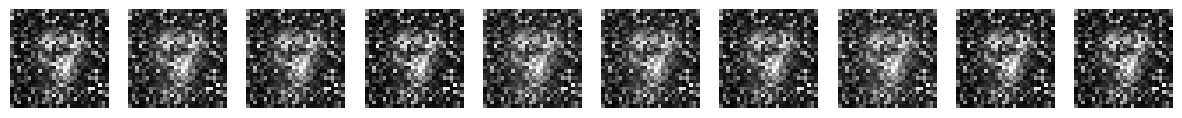

Epoch: 40/200 | Generator Loss: 1.6327878136370482 | Discriminator Loss: 0.4080896986001082


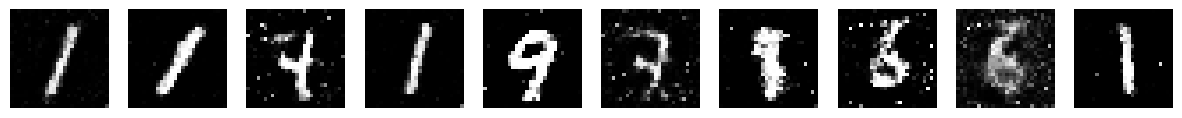

Epoch: 80/200 | Generator Loss: 1.354299812174555 | Discriminator Loss: 0.48136409818490683


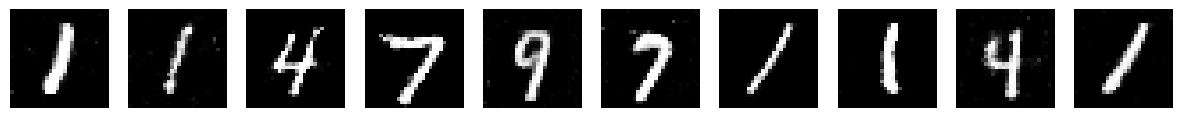

Epoch: 120/200 | Generator Loss: 1.328497620152512 | Discriminator Loss: 0.4943319481255403


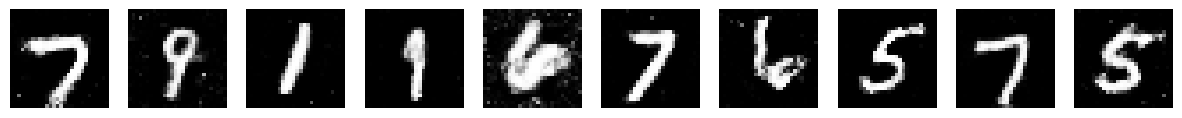

Epoch: 160/200 | Generator Loss: 1.3261665151571669 | Discriminator Loss: 0.4958460940353906


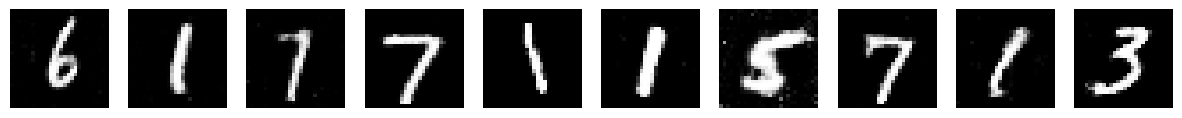

In [8]:
def train_unconditional_gan(generator, 
                            discriminator, 
                            generator_optimizer, 
                            discriminator_optimizer, 
                            dataloader,
                            label_smoothing=0.05,
                            epochs=epochs,
                            device=device, 
                            plot_generation_freq=50,
                            plot_loss_freq=20,
                            num_gens=10):

    ### Define Loss Function (Will do Sigmoid Internally) ###
    loss_func = nn.BCEWithLogitsLoss()

    gen_losses, disc_losses = [], []
    
    for epoch in tqdm(range(epochs)):
    
        generator_epoch_losses = []
        discriminator_epoch_losses = []
        
        for images, _ in dataloader:
    
            batch_size = images.shape[0]
    
            ### These are our real images!! ###
            images = images.to(device)
            
            ########################################################## 
            ################ TRAIN DISCRIMINATOR #####################
            ########################################################## 
            
            ### Sample noise for Generation ###
            noise = torch.randn(batch_size, latent_dimension, device=device)

            ### Create Labels for Discriminator with label smoothing ###
            generated_labels = torch.zeros(batch_size, 1, device=device) + label_smoothing
            true_labels = torch.ones(batch_size, 1, device=device) - label_smoothing
    
            ### Generate Samples G(z) and Take Off Computational Graph ###
            generated_images = generator(noise).detach()

            ### Pass Generated and Real Images into Discriminator ###
            real_discriminator_pred = discriminator(images) 
            gen_discriminator_pred = discriminator(generated_images)

            ### Compute Discriminator Loss ###
            real_loss = loss_func(real_discriminator_pred, true_labels)
            fake_loss = loss_func(gen_discriminator_pred, generated_labels)
            discriminator_loss = (real_loss + fake_loss) / 2
            discriminator_epoch_losses.append(discriminator_loss.item())

            ### Update Discriminator ###
            discriminator_optimizer.zero_grad()
            discriminator_loss.backward()
            discriminator_optimizer.step()

            ########################################################## 
            ################## TRAIN GENERATOR #######################
            ########################################################## 
            
            ### Sample noise for Generation ###
            noise = torch.randn(batch_size, latent_dimension, device=device)

            ### Generate Images ###
            generated_images = generator(noise)

            ### Pass Into Discriminator (to fool) ###
            gen_discriminator_pred = discriminator(generated_images)

            ### Compute Generator Loss ###
            generator_loss = loss_func(gen_discriminator_pred, true_labels)
            generator_epoch_losses.append(generator_loss.item())

            ### Update the Generator ###
            generator_optimizer.zero_grad()
            generator_loss.backward()
            generator_optimizer.step()
            
        generator_epoch_losses = np.mean(generator_epoch_losses)
        discriminator_epoch_losses = np.mean(discriminator_epoch_losses)
    
        if epoch % plot_loss_freq == 0:
            print(f"Epoch: {epoch}/{epochs} | Generator Loss: {generator_epoch_losses} | Discriminator Loss: {discriminator_epoch_losses}")
    
        gen_losses.append(generator_epoch_losses)
        disc_losses.append(discriminator_epoch_losses)
    
        if epoch % plot_generation_freq == 0:
            generator.eval()
            with torch.no_grad():
                noise_sample = torch.randn(num_gens, latent_dimension, device=device)
                generated_imgs = generator(noise_sample).to("cpu")
        
                fig, ax = plt.subplots(1,num_gens, figsize=(15,5))
        
                for i in range(num_gens):
                    img = (generated_imgs[i].squeeze() + 1)/2
                    ax[i].imshow(img.numpy(), cmap="gray")
                    ax[i].set_axis_off()
        
                plt.show()
                
            generator.train()

    return generator, discriminator, gen_losses, disc_losses

generator, discriminator, gen_losses, disc_losses = train_unconditional_gan(generator=generator, 
                                                                            discriminator=discriminator, 
                                                                            generator_optimizer=gen_optimizer, 
                                                                            discriminator_optimizer=disc_optimizer, 
                                                                            dataloader=trainloader,
                                                                            epochs=epochs,
                                                                            device=device, 
                                                                            plot_generation_freq=40,
                                                                            plot_loss_freq=40)

### <span style="color:LightGreen">Loss Plot</span>

Loss values are a really bad way of determining the quality of generations, there are other methods for this that we can explore later! For now though we can see that initially the discriminator got better at detecting real from fake, so you see a dip in the discriminator loss. But as the generator continued to improve, the discriminator got worse!

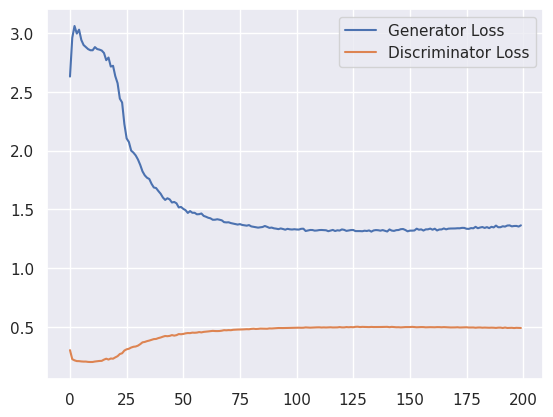

In [9]:
plt.plot(gen_losses, label="Generator Loss")
plt.plot(disc_losses, label="Discriminator Loss")
plt.legend()
plt.show()

## <span style="color:Orange">Conditional GAN</span>

<img src="https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/conditional_gan.png?raw=true" alt="drawing" width="800"/>

Although we have a GAN that can now successfully generate images, what we are missing is the ability to control what is generated! If I want to generate the digit 7, then let me actually control that, not just randomly generate until I get a 7. 

Conditional GAN works exactly like this, and we pass in a conditioning signal. This sounds fancy, but really we are just concatenating on some extra information about which digit we want. We saw in our exploration of [sequence modeling](https://github.com/priyammaz/PyTorch-Adventures/tree/main/PyTorch%20for%20NLP/Recurrent%20Neural%20Networks/IMDB%20Classification) that we have to convert tokens to embeddings, and the embeddings for each token represent their meaning. In the same way, we have the digits 0 - 9 in our dataset, so we will have embeddings for each digit, and that will encode whcih digit we are wanting to generate! Before we had no use for the labels to generate our data, but now we will actually incorporate the MNIST labels to have some control over the generation.

### <span style="color:LightGreen">Why does a Conditional GAN Work?</span>

There will be two embeddings matricies that convert digit labels to vectors, one in the generator and the other in the discriminator. In the generator, we can randomly sample digit labels (for some batch size) and then pass it into our generator with our randomly sampled noise. The generators goal will be to generate an image that matches with the corresponding digit. 

We then concatenate together true images with our generated images (just like before) but also true labels with our previously randomly sampled labels. This stack of true/fake images along with their labels will then be passed to the discriminator, which will have both image data and label data to determine if the images are real or fake. There are then two ways for the discriminator to determine between real and fake images:

1) The generated image looks different from true images (this is what the model was using previously)
2) The relation between true images and their labels is different from the relationship between generated images and their labels.

Therefore, for the generator to successfully fool the discriminator, the model must generate images that look good, but also generate images that match its corresponding label. Therefore, the embeddings in the generator will be squarely for the generative task of creating digits that coorespond with their labels, and the embeddings in discriminator will be for identfying the relationships between those embeddings and real vs fake images.

### <span style="color:LightGreen">Model Details</span>

The only change from our previous model then is adding in the embedding matricies (that will have 10 embeddings for our 10 digits), and a hyperparameter is to determine the embedding dimension.

In [10]:
class MNISTConditionalGenerator(nn.Module):
    def __init__(self, 
                 latent_dimension=100,
                 num_embeddings=10, 
                 embedding_dim=16):
        
        super().__init__()

        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        
        self.generator = nn.Sequential(
            nn.Linear(latent_dimension+embedding_dim, 256),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        batch_size = noise.shape[0]

        ### Get Digit Embeddings ###
        embeddings = self.embeddings(labels)

        ### Concat Embeddings onto Noise ###
        noise = torch.cat([noise, embeddings], dim=-1)
     
        ### Pass Noise+Embeddings into Generator ###    
        generated = self.generator(noise)
        return generated.reshape(batch_size, 1, 28, 28)

class MNISTConditionalDiscriminator(nn.Module):
    def __init__(self, 
                 num_embeddings=10, 
                 embedding_dim=16):
        super().__init__()

        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        
        self.discriminator = nn.Sequential(
            nn.Linear(784+embedding_dim, 1024),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 1),
        )

    def forward(self, x, labels):
        batch_size = x.shape[0]

        ### Get Digit Embeddings ###
        embeddings = self.embeddings(labels)

        ### Flatten Images to Vectors ###
        x = x.reshape(batch_size, -1)

        ### Concat Embeddings to Images ###
        x = torch.cat([x, embeddings], dim=-1)
        
        return self.discriminator(x)

### <span style="color:LightGreen">Train Conditional GAN</span>

This is basically the same as before! Just need to add in the extra step of randomly generating labels as well!

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0/200 | Generator Loss: 2.714516445327161 | Discriminator Loss: 0.29023685201462396


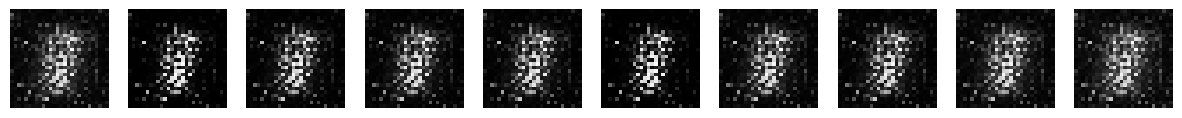

Epoch: 40/200 | Generator Loss: 1.1178556451284047 | Discriminator Loss: 0.5631598981776471


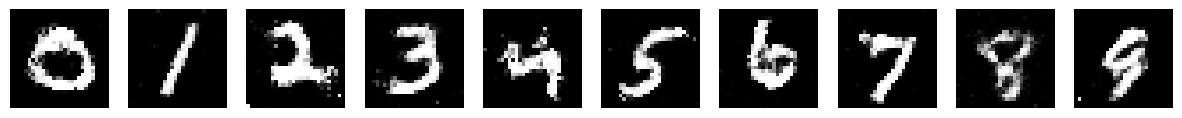

Epoch: 80/200 | Generator Loss: 1.0567189980544516 | Discriminator Loss: 0.5803023697470805


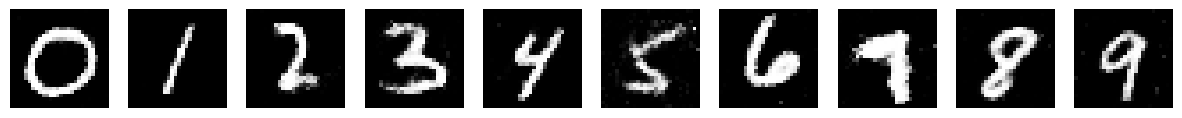

Epoch: 120/200 | Generator Loss: 1.103743928073566 | Discriminator Loss: 0.5693011011904491


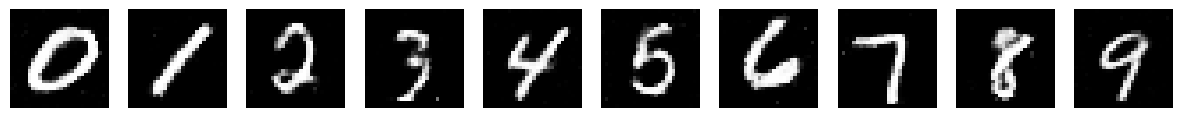

Epoch: 160/200 | Generator Loss: 1.1755260525863054 | Discriminator Loss: 0.5526353868403668


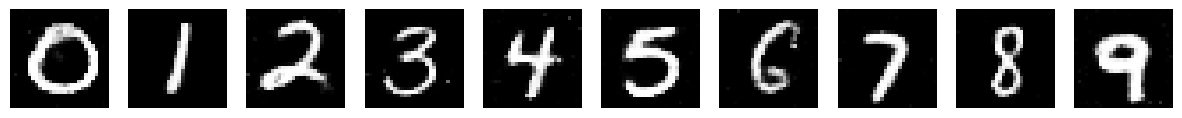

In [11]:
generator_learning_rate = 0.0001
discriminator_learning_rate = 0.0001

### Define Models ###
generator = MNISTConditionalGenerator().to(device)
discriminator = MNISTConditionalDiscriminator().to(device)

### Define Optimizers ###
gen_optimizer = optim.Adam(generator.parameters(), generator_learning_rate)
disc_optimizer = optim.Adam(discriminator.parameters(), discriminator_learning_rate)

def train_conditional_gan(generator, 
                          discriminator, 
                          generator_optimizer, 
                          discriminator_optimizer, 
                          dataloader,
                          label_smoothing=0.05,
                          epochs=epochs,
                          device=device, 
                          plot_generation_freq=50,
                          plot_loss_freq=20,
                          num_classes=10):

    ### Define Loss Function (Will do Sigmoid Internally) ###
    loss_func = nn.BCEWithLogitsLoss()

    gen_losses, disc_losses = [], []
    
    for epoch in tqdm(range(epochs)):
    
        generator_epoch_losses = []
        discriminator_epoch_losses = []
        
        for images, true_digits in dataloader:
    
            batch_size = images.shape[0]
    
            ### These are our real images!! ###
            images = images.to(device)
            true_digits = true_digits.to(device)
            
            ########################################################## 
            ################ TRAIN DISCRIMINATOR #####################
            ########################################################## 
            
            ### NEW: Sample noise/random digits for Generation ###
            rand_digits = torch.randint(0,num_classes, size=(batch_size,), device=device)
            noise = torch.randn(batch_size, latent_dimension, device=device)

            ### Create Labels for Discriminator with label smoothing ###
            generated_labels = torch.zeros(batch_size, 1, device=device) + label_smoothing
            true_labels = torch.ones(batch_size, 1, device=device) - label_smoothing
    
            ### Generate Samples G(z) and Take Off Computational Graph ###
            generated_images = generator(noise, rand_digits).detach()

            ### Pass Generated and Real Images into Discriminator ###
            real_discriminator_pred = discriminator(images, true_digits) 
            gen_discriminator_pred = discriminator(generated_images, rand_digits)

            ### Compute Discriminator Loss ###
            real_loss = loss_func(real_discriminator_pred, true_labels)
            fake_loss = loss_func(gen_discriminator_pred, generated_labels)
            discriminator_loss = (real_loss + fake_loss) / 2
            discriminator_epoch_losses.append(discriminator_loss.item())

            ### Update Discriminator ###
            discriminator_optimizer.zero_grad()
            discriminator_loss.backward()
            discriminator_optimizer.step()

            ########################################################## 
            ################## TRAIN GENERATOR #######################
            ########################################################## 
            
            ### NEW: Sample noise for Generation ###
            rand_digits = torch.randint(0,num_classes, size=(batch_size,), device=device)
            noise = torch.randn(batch_size, latent_dimension, device=device)

            ### Generate Images ###
            generated_images = generator(noise, rand_digits)

            ### Pass Into Discriminator (to fool) ###
            gen_discriminator_pred = discriminator(generated_images, rand_digits)

            ### Compute Generator Loss ###
            generator_loss = loss_func(gen_discriminator_pred, true_labels)
            generator_epoch_losses.append(generator_loss.item())

            ### Update the Generator ###
            generator_optimizer.zero_grad()
            generator_loss.backward()
            generator_optimizer.step()
            
        generator_epoch_losses = np.mean(generator_epoch_losses)
        discriminator_epoch_losses = np.mean(discriminator_epoch_losses)
    
        if epoch % plot_loss_freq == 0:
            print(f"Epoch: {epoch}/{epochs} | Generator Loss: {generator_epoch_losses} | Discriminator Loss: {discriminator_epoch_losses}")
    
        gen_losses.append(generator_epoch_losses)
        disc_losses.append(discriminator_epoch_losses)
    
        if epoch % plot_generation_freq == 0:
            generator.eval()
            with torch.no_grad():
                digits = torch.arange(num_classes, device=device)
                noise_sample = torch.randn(num_classes, latent_dimension, device=device)
                generated_imgs = generator(noise_sample, digits).to("cpu")
        
                fig, ax = plt.subplots(1,num_classes, figsize=(15,5))
        
                for i in range(num_classes):
                    img = (generated_imgs[i].squeeze() + 1)/2
                    ax[i].imshow(img.numpy(), cmap="gray")
                    ax[i].set_axis_off()
        
                plt.show()
                
            generator.train()

    return generator, discriminator, gen_losses, disc_losses
    
generator, discriminator, gen_losses, disc_losses = train_conditional_gan(generator=generator, 
                                                                          discriminator=discriminator, 
                                                                          generator_optimizer=gen_optimizer, 
                                                                          discriminator_optimizer=disc_optimizer, 
                                                                          dataloader=trainloader,
                                                                          epochs=epochs,
                                                                          device=device, 
                                                                          plot_generation_freq=40,
                                                                          plot_loss_freq=40)

## <span style="color:Orange">What about Convolutions?</span>

So now we have a working idea of GANs being applied for conditional and unconditional tasks! But we have only been using linear layer, and if we are working with images, we know mechanisms like Convolutions are much better! So lets try to do exactly what we did, just rebuild the model with Convolutions instead.

### <span style="color:LightGreen">Upsampling</span>

There are a bunch of ways we can do this actually, but the main idea is, if our final image is of size 28x28, we can start by creating a tensor of size 7x7, and use either transpose convolutions to upsample, or we can use basic biliear upsampling + convolution. This way we will upsample from (7x7) -> (14x14) -> (28x28) giving us the image size we want.

### <span style="color:LightGreen">Noise and Conditioning</span>

The other thing is how we do our noise, and there are again a few ways to do this. For simplicity today, we will sample some latent_dimension (currently 100), concatenate our digit embeddings, and then use a linear layer to project it to a (in_channels x 7 x 7), where the number of input channels is a hyperparameter. We could also generate noise in the (in_channels x 7 x 7) shape we want to begin with, but then adding a conditioning signal becomes slightly more complicated and I'm going for barebones here for an introductory tutorial.

When we look at [Diffusion](https://github.com/priyammaz/PyTorch-Adventures/tree/main/PyTorch%20for%20Generation/Diffusion/Conditional%20Diffusion) later we will explore the more complex Cross-Attention and Additive Conditioning, so for now lets just do this the easist way possible!



___<span style="color:Violet">Note: No Change to the Discriminator___</span>: Because MNIST is such a simple dataset we can probably just leave the discriminator as the regular ```MNISTConditionalDiscriminator``` we wrote earlier. In more complex generative tasks, we will have to explore more complex discriminators that leverage convolutions (i.e. PatchGAN), but for now lets keep it simple!


In [12]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, interpolate=False):
        super().__init__()
        if interpolate:
            self.upsample = nn.Sequential(
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_channels, 
                          out_channels, 
                          kernel_size=3, 
                          padding="same")
            )

        else:

            # I just messed with the padding and output padding to ensure that
            # (7x7) goes to (14x14) and (14x14) goes to (28x28)
            # So we always have a 2x upsample
            self.upsample = nn.ConvTranspose2d(in_channels, 
                                               out_channels,
                                               kernel_size=3, 
                                               stride=2, 
                                               padding=1, 
                                               output_padding=1)
            

    def forward(self, x):
        return self.upsample(x)
        
class ConvMNISTConditionalGenerator(nn.Module):
    def __init__(self, 
                 in_channels=128,
                 start_dim=7,
                 latent_dimension=100,
                 num_embeddings=10, 
                 embedding_dim=16,
                 interpolate=False):
        
        super().__init__()

        self.start_dim = start_dim
        self.in_channels = in_channels
        
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)

        self.lin2img = nn.Linear(latent_dimension+embedding_dim, in_channels * start_dim * start_dim)
        
        self.generator = nn.Sequential(
            UpsampleBlock(in_channels, 256),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,128,kernel_size=3, padding="same"), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            UpsampleBlock(128, 64),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,1,kernel_size=3, padding="same"), 
            nn.Tanh()
        )

    def forward(self, noise, labels):
        batch_size = noise.shape[0]

        ### Get Digit Embeddings ###
        embeddings = self.embeddings(labels)

        ### Concat Embeddings onto Noise ###
        noise = torch.cat([noise, embeddings], dim=-1)

        ### Project Noise to Img Space ###
        noise = self.lin2img(noise)

        ### Reshape Noise to Image Shape ###
        noise = noise.reshape(batch_size, self.in_channels, self.start_dim, self.start_dim)
     
        ### Pass Noise+Embeddings into Generator ###    
        generated = self.generator(noise)
        
        return generated.reshape(batch_size, 1, 28, 28)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0/200 | Generator Loss: 2.065079904441386 | Discriminator Loss: 0.3847251913504306


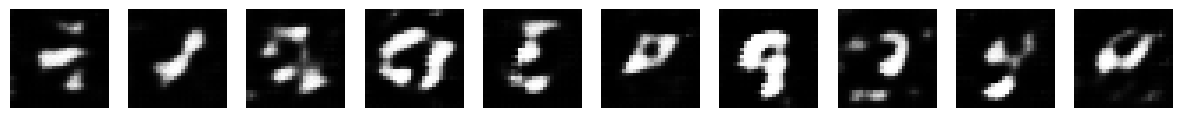

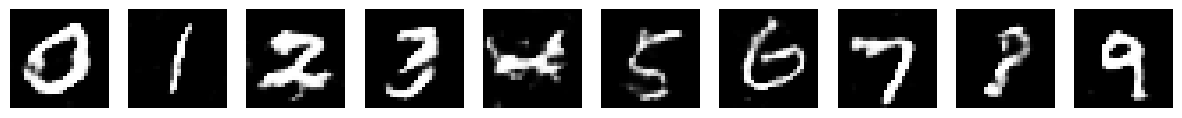

Epoch: 40/200 | Generator Loss: 0.7191067027893148 | Discriminator Loss: 0.6884513026488616


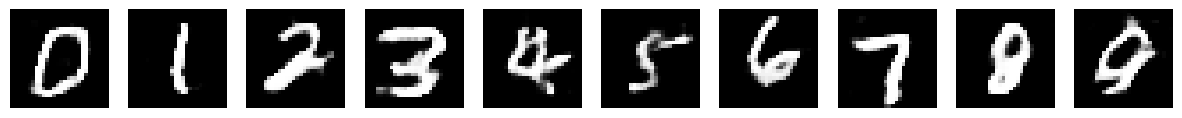

Epoch: 80/200 | Generator Loss: 0.703067980595489 | Discriminator Loss: 0.6898242350199075


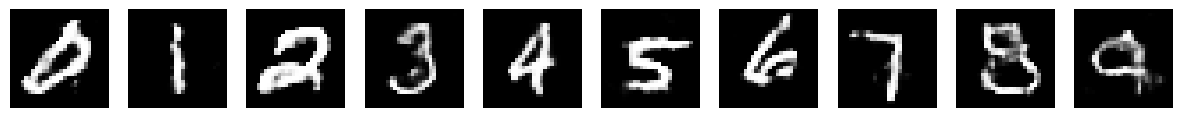

Epoch: 120/200 | Generator Loss: 0.7045717878001077 | Discriminator Loss: 0.6908398996919457


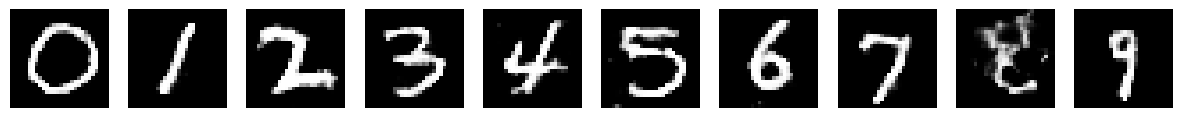

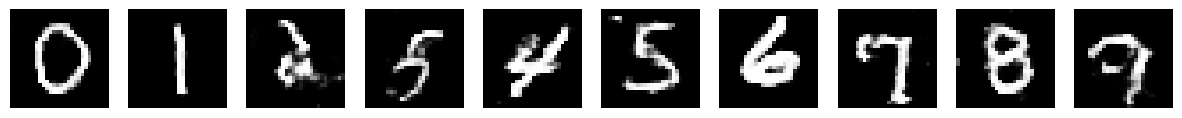

Epoch: 160/200 | Generator Loss: 0.7956475625033064 | Discriminator Loss: 0.6594471512699941


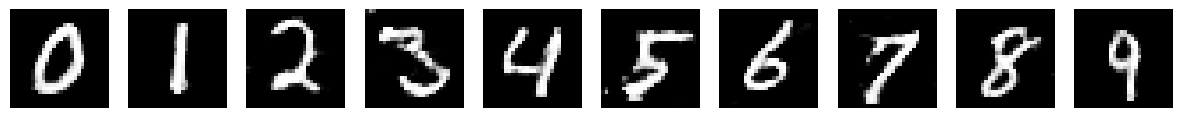

In [13]:
generator_learning_rate = 0.0001
discriminator_learning_rate = 0.0001

### Define Models ###
generator = ConvMNISTConditionalGenerator(interpolate=False).to(device)
discriminator = MNISTConditionalDiscriminator().to(device)

### Define Optimizers ###
gen_optimizer = optim.Adam(generator.parameters(), generator_learning_rate)
disc_optimizer = optim.Adam(discriminator.parameters(), discriminator_learning_rate)


generator, discriminator, gen_losses, disc_losses = train_conditional_gan(generator=generator, 
                                                                          discriminator=discriminator, 
                                                                          generator_optimizer=gen_optimizer, 
                                                                          discriminator_optimizer=disc_optimizer, 
                                                                          dataloader=trainloader,
                                                                          epochs=epochs,
                                                                          device=device, 
                                                                          plot_generation_freq=30,
                                                                          plot_loss_freq=40)

## <span style="color:Orange">Fin</span>

That should get you started if you want to do more exploration of GANs. I personally don't see GANs being used directly as much anymore and Diffusion models provide better generative capabilities, but the GAN Loss on the other hand is employed quite a bit to promote realism when training!

## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer
  * Modified from the following [tutorial](https://github.com/priyammaz/PyTorch-Adventures/tree/main/PyTorch%20for%20Generation/Generative%20Adversarial%20Network)

© Copyright 2025